# Appling machine learning to audio analysis

## Trainning Code - Using cut audios of setA. No moving windows.

### Libraries

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2022-01-29 11:40:59.793580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-29 11:40:59.793643: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# To play audio file:
import IPython.display as ipd

In [ ]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

## MFCCs - Mel-Frequency Cepstrum Coefficients

### Function to extract the MFCCs from every file in our dataset

In [10]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name) 
    audio = shannonEnergy(audio)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    
    mfccs_out = mfccs_processed
     
    return mfccs_out

In [11]:
def shannonEnergy(audio):
    audioShannon = []
    maxAudio = np.ndarray.max(audio)

    for i in audio:
        if i < 10**(-5):
            audioShannon.append(0)

        else:
            i = i/maxAudio
            energyS = -(i**2)*np.log10(i**2)
            audioShannon.append(energyS)

    audioPlot = np.array(audioShannon)
    meanShannon = np.mean(audioPlot)
    stdShannon = np.std(audioPlot)

    Power = []
    for i in audioPlot:
        Power.append((i - meanShannon)/stdShannon)

    powerPlot = np.array(audioShannon)
    return powerPlot

In [12]:
df = pd.read_csv('../csvFiles/newTiming.csv')

In [13]:
from os.path import exists

In [14]:
sounds = []# Iterate through each sound file and extract the sound type
cont = 0 #Conta os ficheiros que tiveram os MFCCs analizados
i = 0 # numero total de ficheiros

for index, row in df.iterrows():
    file_name = df.loc[index]['fname']
    class_label = df.loc[index]['sound']
    
    if 'noise' in class_label:
        class_label = 'noise'
    
    print(class_label)
    i+=1
    
    if (exists(file_name)):
        file_size = os.path.getsize(file_name)
        
        if (file_size > 44):
            data = extract_features(file_name)
            
            sounds.append([data, class_label])
            cont += 1
        else:
            print(file_name)
            
print(i, cont)
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(sounds, columns=['soundtype','class_label'])

S1
S2


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1750
  warnings.warn(


S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1751
  warnings.warn(


S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S1
S2
S

/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1222
  warnings.warn(


noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1122
  warnings.warn(


noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1888
  warnings.warn(


noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=927
  warnings.warn(


noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1694
  warnings.warn(


noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=833
  warnings.warn(


noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1764
  warnings.warn(


noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=2018
  warnings.warn(


noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise


/home/chico/Desktop/taad/projetoNew/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=792
  warnings.warn(


noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
noise
801 800


In [15]:
featuresdf
featuresdf.iloc[799]['class_label']
featuresdf.to_pickle('../MFCCs/cutA_toTrain_shannon_mfccs40.pkl') 

## Model building and training

### Load MFFCs from saved files

In [16]:
fileMFCCs = '../MFCCs/cutA_toTrain_shannon_mfccs40.pkl'
featuresdf = pd.read_pickle(fileMFCCs)

### Transform the data to arrays

In [17]:
keras.backend.clear_session()
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.soundtype.tolist())
print(X)
y = np.array(featuresdf.class_label.tolist())


# Encode the classification labels
le = LabelEncoder()

yy = to_categorical(le.fit_transform(y))

[[-2.13366600e+02  1.40029192e+02  3.54108271e+00 ...  4.36233412e+00
   2.27809413e+00 -1.23335721e+00]
 [-2.26524847e+02  1.26118325e+02  2.10862990e+00 ...  9.33468460e-01
   2.56222118e+00  2.41033463e+00]
 [-2.17119395e+02  1.39897362e+02  7.27108194e+00 ... -5.09224584e+00
  -1.22394119e+00  1.77096963e+00]
 ...
 [-5.96317334e+02  1.70361828e+02  6.77417602e+01 ... -1.35860925e-01
  -1.09092087e+00 -1.60821462e+00]
 [-4.45941936e+02  2.17541951e+02  5.70649730e+01 ...  1.58631073e+00
   1.87309788e+00  1.78981948e-01]
 [-4.50263544e+02  2.15772919e+02  5.54107603e+01 ...  2.64309403e+00
  -1.09029596e+00  1.16150876e+00]]


### Trainning and test sets

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

### Neural Network architecture

In [20]:

num_labels = yy.shape[1]

filter_size = 2

def build_model_graph(input_shape=(40,)):
    model = Sequential()
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
    
    return model

model = build_model_graph()

# Display model architecture summary 
model(x_train)
model.summary()# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (640, 512)                20992     
                                                                 
 activation_4 (Activation)   (640, 512)                0         
                                                                 
 dropout_3 (Dropout)         (640, 512)                0         
                                                                 
 dense_5 (Dense)             (640, 512)                262656    
                                                                 
 activation_5 (Activation)   (640, 512)                0         
                                                                 
 dropout_4 (Dropout)         (640, 512)                0         
                                                                 
 dense_6 (Dense)             (640, 512)               

### Model Trainning

In [21]:
num_epochs = 700
num_batch_size = 32

csv_logger = keras.callbacks.CSVLogger('../model_save/cut_setA_Train_shannon_mffcs40_Hist_700.log')

model.fit(x_train, y_train, batch_size=num_batch_size,callbacks=[csv_logger], epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Epoch 1/700
20/20 [==============================] - 2s 30ms/step - loss: 21.4712 - accuracy: 0.3734 - val_loss: 1.9041 - val_accuracy: 0.4062
Epoch 2/700
20/20 [==============================] - 0s 23ms/step - loss: 11.0180 - accuracy: 0.4141 - val_loss: 2.7864 - val_accuracy: 0.3187
Epoch 3/700
20/20 [==============================] - 1s 26ms/step - loss: 8.2047 - accuracy: 0.3797 - val_loss: 1.1272 - val_accuracy: 0.4750
Epoch 4/700
20/20 [==============================] - 1s 30ms/step - loss: 4.4358 - accuracy: 0.4578 - val_loss: 0.9795 - val_accuracy: 0.4812
Epoch 5/700
20/20 [==============================] - 1s 29ms/step - loss: 3.7793 - accuracy: 0.4563 - val_loss: 1.0736 - val_accuracy: 0.5063
Epoch 6/700
20/20 [==============================] - 0s 24ms/step - loss: 2.9788 - accuracy: 0.4313 - val_loss: 0.8508 - val_accuracy: 0.6750
Epoch 7/700
20/20 [==============================] - 1s 35ms/step - loss: 2.5221 - accuracy: 0.4688 - val_loss: 0.9316 - val_accuracy: 0.5000
Epoc

20/20 [==============================] - 1s 32ms/step - loss: 0.3555 - accuracy: 0.8250 - val_loss: 0.4568 - val_accuracy: 0.8375
Epoch 116/700
20/20 [==============================] - 1s 36ms/step - loss: 0.3189 - accuracy: 0.8484 - val_loss: 0.5103 - val_accuracy: 0.8125
Epoch 117/700
20/20 [==============================] - 1s 40ms/step - loss: 0.3231 - accuracy: 0.8578 - val_loss: 0.4990 - val_accuracy: 0.8500
Epoch 118/700
20/20 [==============================] - 1s 41ms/step - loss: 0.3332 - accuracy: 0.8625 - val_loss: 0.4739 - val_accuracy: 0.8375
Epoch 119/700
20/20 [==============================] - 1s 42ms/step - loss: 0.3489 - accuracy: 0.8531 - val_loss: 0.4875 - val_accuracy: 0.8500
Epoch 120/700
20/20 [==============================] - 1s 29ms/step - loss: 0.3264 - accuracy: 0.8484 - val_loss: 0.4779 - val_accuracy: 0.8313
Epoch 121/700
20/20 [==============================] - 1s 31ms/step - loss: 0.3396 - accuracy: 0.8453 - val_loss: 0.4755 - val_accuracy: 0.8438
Epoch 

Epoch 172/700
20/20 [==============================] - 1s 26ms/step - loss: 0.2623 - accuracy: 0.8922 - val_loss: 0.5808 - val_accuracy: 0.8438
Epoch 173/700
20/20 [==============================] - 1s 28ms/step - loss: 0.2157 - accuracy: 0.9125 - val_loss: 0.5665 - val_accuracy: 0.8375
Epoch 174/700
20/20 [==============================] - 1s 35ms/step - loss: 0.2005 - accuracy: 0.9234 - val_loss: 0.5809 - val_accuracy: 0.8562
Epoch 175/700
20/20 [==============================] - 1s 31ms/step - loss: 0.1870 - accuracy: 0.9203 - val_loss: 0.5973 - val_accuracy: 0.8562
Epoch 176/700
20/20 [==============================] - 1s 36ms/step - loss: 0.2517 - accuracy: 0.9000 - val_loss: 0.6048 - val_accuracy: 0.8375
Epoch 177/700
20/20 [==============================] - 1s 29ms/step - loss: 0.2176 - accuracy: 0.9203 - val_loss: 0.5317 - val_accuracy: 0.8313
Epoch 178/700
20/20 [==============================] - 1s 34ms/step - loss: 0.2170 - accuracy: 0.9109 - val_loss: 0.5504 - val_accuracy:

Epoch 229/700
20/20 [==============================] - 1s 32ms/step - loss: 0.2000 - accuracy: 0.9187 - val_loss: 0.7974 - val_accuracy: 0.8250
Epoch 230/700
20/20 [==============================] - 1s 44ms/step - loss: 0.1732 - accuracy: 0.9391 - val_loss: 0.6304 - val_accuracy: 0.8375
Epoch 231/700
20/20 [==============================] - 1s 57ms/step - loss: 0.1466 - accuracy: 0.9312 - val_loss: 0.6056 - val_accuracy: 0.8625
Epoch 232/700
20/20 [==============================] - 1s 57ms/step - loss: 0.1874 - accuracy: 0.9359 - val_loss: 0.6710 - val_accuracy: 0.8375
Epoch 233/700
20/20 [==============================] - 1s 53ms/step - loss: 0.1768 - accuracy: 0.9250 - val_loss: 0.6382 - val_accuracy: 0.8250
Epoch 234/700
20/20 [==============================] - 1s 57ms/step - loss: 0.1930 - accuracy: 0.9328 - val_loss: 0.5381 - val_accuracy: 0.8375
Epoch 235/700
20/20 [==============================] - 1s 51ms/step - loss: 0.1668 - accuracy: 0.9344 - val_loss: 0.5866 - val_accuracy:

Epoch 286/700
20/20 [==============================] - 1s 30ms/step - loss: 0.1290 - accuracy: 0.9453 - val_loss: 0.6697 - val_accuracy: 0.8500
Epoch 287/700
20/20 [==============================] - 1s 28ms/step - loss: 0.0901 - accuracy: 0.9625 - val_loss: 0.7468 - val_accuracy: 0.8687
Epoch 288/700
20/20 [==============================] - 1s 31ms/step - loss: 0.1410 - accuracy: 0.9516 - val_loss: 0.7704 - val_accuracy: 0.8625
Epoch 289/700
20/20 [==============================] - 1s 29ms/step - loss: 0.1019 - accuracy: 0.9547 - val_loss: 0.7354 - val_accuracy: 0.8687
Epoch 290/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1366 - accuracy: 0.9438 - val_loss: 0.9696 - val_accuracy: 0.8375
Epoch 291/700
20/20 [==============================] - 0s 25ms/step - loss: 0.1725 - accuracy: 0.9328 - val_loss: 0.7008 - val_accuracy: 0.8250
Epoch 292/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1545 - accuracy: 0.9500 - val_loss: 0.8071 - val_accuracy:

Epoch 343/700
20/20 [==============================] - 1s 30ms/step - loss: 0.1392 - accuracy: 0.9422 - val_loss: 0.7459 - val_accuracy: 0.8562
Epoch 344/700
20/20 [==============================] - 1s 32ms/step - loss: 0.1295 - accuracy: 0.9500 - val_loss: 0.7679 - val_accuracy: 0.8375
Epoch 345/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1455 - accuracy: 0.9406 - val_loss: 0.8353 - val_accuracy: 0.8500
Epoch 346/700
20/20 [==============================] - 1s 26ms/step - loss: 0.1674 - accuracy: 0.9469 - val_loss: 0.7355 - val_accuracy: 0.8625
Epoch 347/700
20/20 [==============================] - 1s 27ms/step - loss: 0.1965 - accuracy: 0.9187 - val_loss: 0.7924 - val_accuracy: 0.8188
Epoch 348/700
20/20 [==============================] - 1s 29ms/step - loss: 0.1692 - accuracy: 0.9406 - val_loss: 0.7001 - val_accuracy: 0.8188
Epoch 349/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1306 - accuracy: 0.9516 - val_loss: 0.7342 - val_accuracy:

Epoch 400/700
20/20 [==============================] - 1s 33ms/step - loss: 0.1499 - accuracy: 0.9453 - val_loss: 0.9326 - val_accuracy: 0.8562
Epoch 401/700
20/20 [==============================] - 1s 31ms/step - loss: 0.1770 - accuracy: 0.9391 - val_loss: 0.8354 - val_accuracy: 0.8375
Epoch 402/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1252 - accuracy: 0.9531 - val_loss: 0.9389 - val_accuracy: 0.8250
Epoch 403/700
20/20 [==============================] - 0s 25ms/step - loss: 0.1262 - accuracy: 0.9609 - val_loss: 0.8007 - val_accuracy: 0.8500
Epoch 404/700
20/20 [==============================] - 1s 27ms/step - loss: 0.1294 - accuracy: 0.9594 - val_loss: 0.6868 - val_accuracy: 0.8375
Epoch 405/700
20/20 [==============================] - 1s 26ms/step - loss: 0.1165 - accuracy: 0.9625 - val_loss: 0.7933 - val_accuracy: 0.8500
Epoch 406/700
20/20 [==============================] - 1s 33ms/step - loss: 0.0773 - accuracy: 0.9656 - val_loss: 0.9511 - val_accuracy:

Epoch 457/700
20/20 [==============================] - 1s 30ms/step - loss: 0.1225 - accuracy: 0.9500 - val_loss: 0.9437 - val_accuracy: 0.8500
Epoch 458/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1411 - accuracy: 0.9469 - val_loss: 0.9581 - val_accuracy: 0.8438
Epoch 459/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1867 - accuracy: 0.9422 - val_loss: 0.7591 - val_accuracy: 0.8375
Epoch 460/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1257 - accuracy: 0.9547 - val_loss: 0.8475 - val_accuracy: 0.8500
Epoch 461/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1041 - accuracy: 0.9641 - val_loss: 1.0239 - val_accuracy: 0.8375
Epoch 462/700
20/20 [==============================] - 1s 30ms/step - loss: 0.1362 - accuracy: 0.9547 - val_loss: 1.0913 - val_accuracy: 0.8313
Epoch 463/700
20/20 [==============================] - 1s 27ms/step - loss: 0.1268 - accuracy: 0.9688 - val_loss: 0.9533 - val_accuracy:

Epoch 514/700
20/20 [==============================] - 1s 32ms/step - loss: 0.1158 - accuracy: 0.9609 - val_loss: 0.9522 - val_accuracy: 0.8250
Epoch 515/700
20/20 [==============================] - 1s 27ms/step - loss: 0.1808 - accuracy: 0.9438 - val_loss: 1.0771 - val_accuracy: 0.8188
Epoch 516/700
20/20 [==============================] - 0s 24ms/step - loss: 0.1312 - accuracy: 0.9531 - val_loss: 0.9014 - val_accuracy: 0.8250
Epoch 517/700
20/20 [==============================] - 1s 27ms/step - loss: 0.1298 - accuracy: 0.9656 - val_loss: 0.8564 - val_accuracy: 0.8313
Epoch 518/700
20/20 [==============================] - 1s 33ms/step - loss: 0.1052 - accuracy: 0.9688 - val_loss: 0.8188 - val_accuracy: 0.8375
Epoch 519/700
20/20 [==============================] - 1s 29ms/step - loss: 0.0996 - accuracy: 0.9641 - val_loss: 0.9456 - val_accuracy: 0.8375
Epoch 520/700
20/20 [==============================] - 1s 29ms/step - loss: 0.0936 - accuracy: 0.9609 - val_loss: 0.9495 - val_accuracy:

Epoch 571/700
20/20 [==============================] - 1s 29ms/step - loss: 0.0717 - accuracy: 0.9703 - val_loss: 0.8730 - val_accuracy: 0.8500
Epoch 572/700
20/20 [==============================] - 1s 31ms/step - loss: 0.0964 - accuracy: 0.9703 - val_loss: 1.0027 - val_accuracy: 0.8188
Epoch 573/700
20/20 [==============================] - 1s 31ms/step - loss: 0.1895 - accuracy: 0.9391 - val_loss: 0.8914 - val_accuracy: 0.8188
Epoch 574/700
20/20 [==============================] - 1s 28ms/step - loss: 0.0828 - accuracy: 0.9734 - val_loss: 0.8103 - val_accuracy: 0.8500
Epoch 575/700
20/20 [==============================] - 1s 29ms/step - loss: 0.0981 - accuracy: 0.9656 - val_loss: 0.8642 - val_accuracy: 0.8500
Epoch 576/700
20/20 [==============================] - 1s 25ms/step - loss: 0.1648 - accuracy: 0.9422 - val_loss: 1.0916 - val_accuracy: 0.8188
Epoch 577/700
20/20 [==============================] - 1s 27ms/step - loss: 0.1485 - accuracy: 0.9531 - val_loss: 0.9075 - val_accuracy:

Epoch 628/700
20/20 [==============================] - 1s 29ms/step - loss: 0.0805 - accuracy: 0.9719 - val_loss: 0.8904 - val_accuracy: 0.8625
Epoch 629/700
20/20 [==============================] - 1s 25ms/step - loss: 0.0990 - accuracy: 0.9734 - val_loss: 0.8866 - val_accuracy: 0.8250
Epoch 630/700
20/20 [==============================] - 1s 26ms/step - loss: 0.1543 - accuracy: 0.9516 - val_loss: 0.8601 - val_accuracy: 0.8562
Epoch 631/700
20/20 [==============================] - 1s 31ms/step - loss: 0.1571 - accuracy: 0.9500 - val_loss: 0.9126 - val_accuracy: 0.8375
Epoch 632/700
20/20 [==============================] - 1s 29ms/step - loss: 0.0751 - accuracy: 0.9750 - val_loss: 0.9565 - val_accuracy: 0.8500
Epoch 633/700
20/20 [==============================] - 1s 28ms/step - loss: 0.0866 - accuracy: 0.9641 - val_loss: 1.1800 - val_accuracy: 0.8062
Epoch 634/700
20/20 [==============================] - 1s 30ms/step - loss: 0.1047 - accuracy: 0.9719 - val_loss: 0.9262 - val_accuracy:

Epoch 685/700
20/20 [==============================] - 1s 26ms/step - loss: 0.1201 - accuracy: 0.9594 - val_loss: 1.0440 - val_accuracy: 0.8313
Epoch 686/700
20/20 [==============================] - 0s 25ms/step - loss: 0.0735 - accuracy: 0.9750 - val_loss: 1.0413 - val_accuracy: 0.8500
Epoch 687/700
20/20 [==============================] - 1s 27ms/step - loss: 0.0724 - accuracy: 0.9766 - val_loss: 1.0808 - val_accuracy: 0.8438
Epoch 688/700
20/20 [==============================] - 0s 25ms/step - loss: 0.1518 - accuracy: 0.9594 - val_loss: 1.0862 - val_accuracy: 0.8313
Epoch 689/700
20/20 [==============================] - 1s 27ms/step - loss: 0.0983 - accuracy: 0.9609 - val_loss: 1.0836 - val_accuracy: 0.8562
Epoch 690/700
20/20 [==============================] - 1s 28ms/step - loss: 0.1257 - accuracy: 0.9547 - val_loss: 0.9472 - val_accuracy: 0.8562
Epoch 691/700
20/20 [==============================] - 1s 27ms/step - loss: 0.0932 - accuracy: 0.9734 - val_loss: 0.9735 - val_accuracy:

In [22]:
model.save('../model_save/cut_setA_Train_shannon_mffcs40_Hist_700/saved_model', save_format='tf')

2022-01-29 11:58:58.987712: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model_save/cut_setA_Train_shannon_mffcs40_Hist_700/saved_model/assets


### Plot of model performance

In [23]:
history = pd.read_csv('../model_save/cut_setA_Train_shannon_mffcs40_Hist_700.log')

Text(0, 0.5, 'Accuracy')

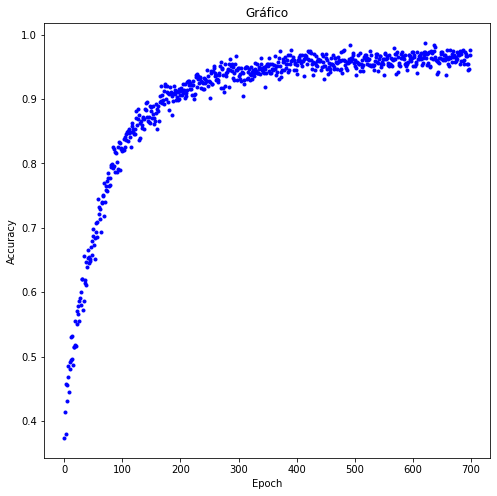

In [24]:
xx = np.array(history.epoch.tolist())
yy = np.array(history.accuracy.tolist())

fig = plt.figure(figsize=(8,8))
Plot = fig.add_subplot(111)

Plot.plot(xx, yy, "b.")

#Plot.axvline(x=Ei, c='red')
#Plot.axhline(y=npy.log(tauN), c='purple')

Plot.title.set_text("Gráfico")
Plot.set_xlabel("Epoch")
Plot.set_ylabel("Accuracy")


In [25]:
fig.savefig('../images/performance/700Epoch_shannon_mfccs40.jpg')

In [ ]:
experiment.end()